# Building a Text Classification Model for Swahili News
### This is a notebook for the task of text classification of swahili news articles.
#### These articles are classified into 5 categories:  
<ul>
    <li>'Kitaifa': 'National',
    <li>'Kimataifa': 'International',
    <li>'Biashara': 'Business',
    <li>'Michezo': 'Sports',
    <li>'Burudani': 'Entertainment'
</ul>

### 1. Importing Libraries

In [44]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import xgboost
from bayes_opt import BayesianOptimization

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
import re
import os

### 2. Exploratory data Analysis

In [45]:
df = pd.read_csv("chatgpt-ml-challenge-swahili-news-classification20230706-4525-yqsxo1/Train.csv")
print(f"The training dataset shape is : {df.shape}")
df.head()

The training dataset shape is : (5151, 3)


,id,content,category
0,SW0,SERIKALI imesema haitakuwa tayari kuona amani...,Kitaifa
1,SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",Biashara
2,SW10,SERIKALI imetoa miezi sita kwa taasisi zote z...,Kitaifa
3,SW100,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,michezo
4,SW1000,WATANZANIA wamekumbushwa kusherehekea sikukuu...,Kitaifa


In [46]:
# Check for missing values
print(df.isna().sum())

id          0
content     0
category    0
dtype: int64


In [48]:
df.category.value_counts()

category
Kitaifa      2000
Michezo      1720
Biashara     1360
Kimataifa      54
Burudani       17
Name: count, dtype: int64

In [47]:
# capitalize the Labels for consistency
df.category = df.category.map(str.capitalize)

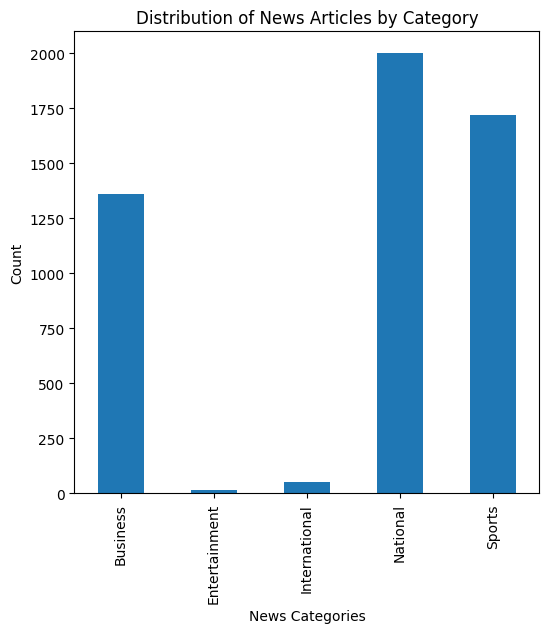

In [63]:
categories = {
    'Kitaifa': 'National',
    'Kimataifa': 'International',
    'Biashara': 'Business',
    'Michezo': 'Sports',
    'Burudani': 'Entertainment'}

plt.figure(figsize=(6,6))
ax = df.groupby("category").content.count().plot.bar()
# Get the tick labels automatically generated by Pandas (Swahili categories)
tick_labels = [tick.get_text() for tick in ax.get_xticklabels()]
# Replace with the corresponding English labels using the dictionary
translated_labels = [categories[label] for label in tick_labels]
# Update the x-axis ticks with the translated labels
plt.xticks(ticks=range(len(tick_labels)), labels=translated_labels)

# Add labels and title
plt.xlabel('News Categories')
plt.ylabel('Count')
plt.title('Distribution of News Articles by Category')

plt.show()

### 3. Preprocessing 

In [50]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) # remove special characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip() # remove double spaces
    return text

df["content"] = df["content"].apply(preprocess_text)

In [51]:
# Drop empty text
df.drop(index=df[df.content == ''].index, inplace=True)

In [52]:
# Encode the categories
encoder = LabelEncoder()
df["enc_category"] = encoder.fit_transform(df["category"])
df.enc_category.value_counts()

enc_category
3    2000
4    1719
0    1359
2      54
1      16
Name: count, dtype: int64

In [53]:
# Open the Swahili stopword file in read mode
with open('chatgpt-ml-challenge-swahili-news-classification20230706-4525-yqsxo1/stopwords-sw.txt', 'r') as f:
    stopwords_sw = []  # Initialize an empty list to store the lines
    for line in f:  # Loop through each line in the file
        stopwords_sw.append(line.strip())  # Append the line after stripping newline characters
print(stopwords_sw)

['akasema', 'alikuwa', 'alisema', 'baada', 'basi', 'bila', 'cha', 'chini', 'hadi', 'hapo', 'hata', 'hivyo', 'hiyo', 'huku', 'huo', 'ili', 'ilikuwa', 'juu', 'kama', 'karibu', 'katika', 'kila', 'kima', 'kisha', 'kubwa', 'kutoka', 'kuwa', 'kwa', 'kwamba', 'kwenda', 'kwenye', 'la', 'lakini', 'mara', 'mdogo', 'mimi', 'mkubwa', 'mmoja', 'moja', 'muda', 'mwenye', 'na', 'naye', 'ndani', 'ng', 'ni', 'nini', 'nonkungu', 'pamoja', 'pia', 'sana', 'sasa', 'sauti', 'tafadhali', 'tena', 'tu', 'vile', 'wa', 'wakati', 'wake', 'walikuwa', 'wao', 'watu', 'wengine', 'wote', 'ya', 'yake', 'yangu', 'yao', 'yeye', 'yule', 'za', 'zaidi', 'zake']


In [54]:
# Apply tf-idf transformation to the text data
tfidf = TfidfVectorizer(sublinear_tf=True,
                        stop_words=stopwords_sw,
                        use_idf=True)
X = tfidf.fit_transform(df.content)
print(f"The training dataset shape: {X.shape}")

The training dataset shape: (5148, 97017)


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, df["enc_category"], test_size=0.2, random_state=0)

### 4. Model Training and evaluation

In [62]:
params = {
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y_train)),
    'learning_rate': 0.1,
    'max_depth': 6,
    #'n_estimators': 100,
    'device': 'cuda',  # GPU-accelerated algorithm
}

dtrain = xgboost.DMatrix(X_train, label=y_train)
dtest = xgboost.DMatrix(X_test, label=y_test)

# Train the model on GPU
model = xgboost.train(params, dtrain)#, num_boost_round=params['n_estimators'])

# Predictions and evaluation
y_pred = model.predict(dtest)
y_pred_classes = np.argmax(y_pred, axis=1)

print(f"accuracy : {accuracy_score(y_true=y_test, y_pred=y_pred_classes)}")
print(f"recall : {recall_score(y_true=y_test, y_pred=y_pred_classes, average="macro")}")
print(f"f1 : {f1_score(y_true=y_test, y_pred=y_pred_classes, average="macro")}")

accuracy : 0.7980582524271844
recall : 0.48041750600825994
f1 : 0.48164396668560416


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true=y_test, y_pred=y_pred_classes, target_names=encoder.inverse_transform(df.enc_category.value_counts().index))
print(report)

              precision    recall  f1-score   support

     Kitaifa       0.84      0.64      0.73       303
     Michezo       0.00      0.00      0.00         1
    Biashara       0.00      0.00      0.00        11
   Kimataifa       0.69      0.84      0.76       380
    Burudani       0.92      0.92      0.92       335

    accuracy                           0.80      1030
   macro avg       0.49      0.48      0.48      1030
weighted avg       0.80      0.80      0.79      1030



#### 4.1 Hyperparameters optimization

In [ ]:
dtrain = xgboost.DMatrix(X_train, label=y_train)
dtest = xgboost.DMatrix(X_test, label=y_test)
# Define the function to optimize
def xgb_evaluate(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree):
    params = {
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y_train)),
        'max_depth': int(max_depth),
        'eta': learning_rate,
        'gamma': gamma,
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'eval_metric': 'mlogloss',
        'device': 'cuda'
    }

    # Train the model
    model = xgboost.train(params, dtrain, num_boost_round=int(n_estimators))

    # Make predictions
    predictions = model.predict(dtest)
    accuracy = f1_score(y_test, predictions, average='macro')
    return accuracy

# Set up the parameter bounds for Bayesian Optimization
param_bounds = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 300),
    'gamma': (0, 5),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1),
}

# Run Bayesian Optimization
optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds=param_bounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(init_points=10, n_iter=30)

# Extract the best parameters
best_params = optimizer.max['params']
# Convert float params to int where necessary
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])

print("Best Parameters:", best_params)

# Train the final model with the best parameters
final_params = {
    'objective': 'multi:softmax',
    'num_class': len(np.unique(y_train)),
    'max_depth': best_params['max_depth'],
    'eta': best_params['learning_rate'],
    'gamma': best_params['gamma'],
    'min_child_weight': best_params['min_child_weight'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'eval_metric': 'mlogloss',
    'device': 'cuda'
}

final_model = xgboost.train(final_params, dtrain, num_boost_round=best_params['n_estimators'])

# Evaluate the final model
final_predictions = final_model.predict(dtest)
final_accuracy = f1_score(y_test, final_predictions, average='macro')
print("Final f1:", final_accuracy)

report = classification_report(y_true=y_test, y_pred=final_predictions, target_names=encoder.inverse_transform(df.enc_category.value_counts().index))
print(report)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.5358    | 0.6873    | 4.754     | 0.2223    | 7.191     | 2.404     | 89.0      | 0.529     |
| 2         | 0.5038    | 0.9331    | 3.006     | 0.2153    | 3.144     | 9.729     | 258.1     | 0.6062    |
| 3         | 0.546     | 0.5909    | 0.917     | 0.09823   | 6.673     | 4.888     | 122.8     | 0.8059    |
| 4         | 0.5081    | 0.5697    | 1.461     | 0.1162    | 6.192     | 8.067     | 99.92     | 0.7571    |
| 5         | 0.5415    | 0.7962    | 0.2323    | 0.1862    | 4.194     | 1.585     | 287.2     | 0.9828    |
| 6         | 0.5024    | 0.9042    | 1.523     | 0.03832   | 7.79      | 4.961     | 80.51     | 0.7476    |
| 7         | 0.507     | 0.5172    | 4.547     | 0.08505   | 7.638     | 3.805     | 180.0     | 0.7734    |
| 8       

### 5. Future improvements

In [60]:
# Feature selection using chi-squared
# # Select top k features using Chi-Squared
k = 10000  # Number of features to keep
chi2_selector = SelectKBest(chi2, k=k)

# Fit the selector on the training data
X_train_selected = chi2_selector.fit_transform(X_train, y_train)

# Transform the test set using the same feature selection
X_test_selected = chi2_selector.transform(X_test)

In [ ]:
# SMOTE
# Word2Vec, BERT, ....